# Kaggle House Price Prediction Task



In [1]:
# Import Packages
import torch
from torch import nn as nn
from torch import optim as optim
import d2lzh_pytorch as d2dl
from torch.utils import data as Data
from torch.nn import init 

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

## Data Preprocessing and Feature Enginerring

- notes：
  - pandas dataframe
    - search
      - df[val]
        - 选取一列或若干列，val为列名
        - val也可以是判断句（boolean array/df）选择列
        - val也可以是切片（0:1）选择行
      - df.loc[index, column_name]：loc是用**行列标签**来索引。index可以是数字切片（前提是index是默认的，若index指明为字符串，则需不能用数字），布尔数组/df，也可以是[1,2]的数字/标签组合。
        - df.loc[0,'name'] 
        - df.loc[0:2, ['name','age']] 	
        - df.loc[[2,3],['name','age']] 		 
        - df.loc[df['gender']=='M','name'] 	 
        - df.loc[df['gender']=='M',['name','age']] #选取gender列是M，name和age列的数据
      - df.iloc[row_index, column_inde]：iloc是用**行列序数**来索引
      - df.at & df.iat[]
  - pandas series
    - series.index
  - pandas concat((data_1,data_2,...),axis): axis=1时列合并
  - sklearn.preprocessing.StandardScaler()
    - sc = StandardScaler()
    - sc.fit(data_1)
    - sc.transform(data_1)
    - sc.transform(data_2)
    - 适合用训练数据的统计量去归一化测试数据

In [2]:
# Obtain Data
train_raw = pd.read_csv('/Users/yanzheyuan/coding/dataset/house-prices-advanced-regression-techniques/train.csv')
test_raw = pd.read_csv('/Users/yanzheyuan/coding/dataset/house-prices-advanced-regression-techniques/test.csv')

print(train_raw.shape)
print(test_raw.shape)


(1460, 81)
(1459, 80)


In [3]:
train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# Feature Selection and Data Preprocessing

train_data = train_raw.iloc[:, 1:-1]
test_data = test_raw.iloc[:, 1:]
print(train_data.shape)
print(test_data.shape)
#print(len(train_data))

# for numerical data we normalize them and fill null data with 0.
numerical_indexes = train_data.dtypes[train_data.dtypes!='object'].index  # dtypes: series(index,value)

sc = StandardScaler()
sc.fit(train_data[numerical_indexes])
train_data[numerical_indexes] = sc.transform(train_data[numerical_indexes])
train_data[numerical_indexes] = train_data[numerical_indexes].fillna(0)

test_data[numerical_indexes] = sc.transform(test_data[numerical_indexes])
test_data[numerical_indexes] = test_data[numerical_indexes].fillna(0)

# for discrete data we dummy them  
all_data = pd.concat((train_data,test_data))
all_data = pd.get_dummies(all_data,dummy_na=True)

train_data = all_data.iloc[:len(train_data)]
test_data = all_data.iloc[len(train_data):]

print(train_data.shape)
print(test_data.shape)


(1460, 79)
(1459, 79)
(1460, 331)
(1459, 331)


## Model Defination and Model Training

In [6]:
# Hyperparameters
num_train = len(train_data)
num_test = len(test_data)
num_features = train_data.shape[1]

num_inputs = num_features
num_outputs = 1
num_hiddens = 128

num_epochs = 100
learning_rate = 5
k = 5
weight_decay = 0
batch_size = 64

# Obtain Data

train_features = torch.tensor(train_data.values,dtype=torch.float32)
train_labels = torch.tensor(train_raw.SalePrice,dtype=torch.float32).view(-1,1)
test_features = torch.tensor(test_data.values,dtype=torch.float32)

# Define Model
net_1 = nn.Linear(num_features,num_outputs)
print('net_1:',net_1)
net_2 = nn.Sequential()
net_2.add_module('linear_1',nn.Linear(num_inputs,num_hiddens))
net_2.add_module('relu',nn.ReLU())
net_2.add_module('linear_2',nn.Linear(num_hiddens,num_outputs))
print('net_2:',net_2)

# initialization of parameters
for param in net_1.parameters():
    torch.nn.init.normal_(param,mean=0,std=0.01)

for param in net_2.parameters():
    torch.nn.init.normal_(param,mean=0,std=0.01)
    
    
loss_func = torch.nn.MSELoss()
optimizor_1 = optim.Adam(net_1.parameters(),lr=learning_rate,weight_decay=weight_decay)
optimizor_2 = optim.Adam(net_2.parameters(),lr=learning_rate,weight_decay=weight_decay)

# evaluation
def log_rmse(net, features, labels, loss_func):
    with torch.no_grad():
        # clipping outliers
        clipping_preds = torch.max(net(features),torch.tensor(1.0))
        rmse = torch.sqrt(loss_func(clipping_preds.log(), labels.log()))
    return rmse.item()


# Train Data
def train(train_features, train_labels, test_features, test_labels, batch_size, net, num_epochs, loss_func, optimizor):
    train_ls, test_ls = [],[]
    dataset = Data.TensorDataset(train_features,train_labels)
    train_iterator = Data.DataLoader(dataset,batch_size,shuffle=True)
    
    net = net.float()
    for epoch in range(num_epochs):
        #total_batch, total_loss = 0,0.0
        for X,y in train_iterator:
            loss = loss_func(net(X.float()),y.float())
            optimizor.zero_grad()
            loss.backward()
            optimizor.step()
            
            #total_batch += 1
            #total_loss += loss.item()
            
        #print('Epoch:%d, Train_MSELoss:%f'%(epoch+1,loss.item()))
        train_ls.append(log_rmse(net,train_features,train_labels,loss_func))
        
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels,loss_func))
    
    return train_ls,test_ls



net_1: Linear(in_features=331, out_features=1, bias=True)
net_2: Sequential(
  (linear_1): Linear(in_features=331, out_features=128, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
)


In [7]:
# Predict
def get_kfold_data(k, X, y, i):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx,:], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else: 
            X_train = torch.cat((X_train, X_part),dim=0)  # concatenate by row
            y_train = torch.cat((y_train, y_part),dim=0)
    
    return X_train, y_train, X_valid, y_valid  

def kfold(k, X_train, y_train, net, num_epochs, loss_func, optimizor):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_kfold_data(k,X_train,y_train,i)
        train_ls, valid_ls = train(*data,batch_size,net,num_epochs,loss_func,optimizor)
        train_l_sum += train_ls[-1]  # new value is the last one for every loop
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2dl.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('-------Fold %d, Train RMSE %f, Valid RMSE %f--------' \
              % (i, train_ls[-1], valid_ls[-1]))
        
    return train_l_sum / k, valid_l_sum / k    # average
     

## Make Predictions and Visualizations

-------Fold 0, Train RMSE 0.168977, Valid RMSE 0.157927--------
-------Fold 1, Train RMSE 0.141474, Valid RMSE 0.151099--------
-------Fold 2, Train RMSE 0.128930, Valid RMSE 0.137321--------
-------Fold 3, Train RMSE 0.129408, Valid RMSE 0.125258--------
-------Fold 4, Train RMSE 0.120805, Valid RMSE 0.147126--------
For:5-Fold Validation: average Train RMSE 0.137919, avg Valid RMSE 0.143746


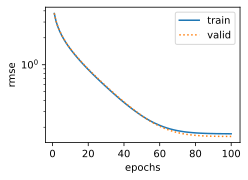

In [8]:
# Do It for Model 1
train_l_1, valid_l_1 = kfold(k,train_features,train_labels,net_1,num_epochs,loss_func,optimizor_1)
print('For:%d-Fold Validation: average Train RMSE %f, avg Valid RMSE %f' % (k, train_l_1, valid_l_1))



-------Fold 0, Train RMSE 0.033924, Valid RMSE 0.162403--------
-------Fold 1, Train RMSE 0.046016, Valid RMSE 0.121062--------
-------Fold 2, Train RMSE 0.131602, Valid RMSE 0.146315--------
-------Fold 3, Train RMSE 0.038243, Valid RMSE 0.095915--------
-------Fold 4, Train RMSE 0.041125, Valid RMSE 0.096676--------
For:5-Fold Validation: average Train RMSE 0.058182, avg Valid RMSE 0.124474


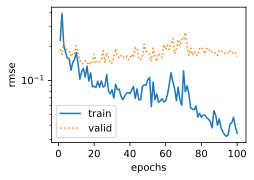

In [9]:
# Do It for Model 2
train_l_2, valid_l_2 = kfold(k,train_features,train_labels,net_2,num_epochs,loss_func,optimizor_2)
print('For:%d-Fold Validation: average Train RMSE %f, avg Valid RMSE %f' % (k, train_l_2, valid_l_2))


train rmse 0.123741


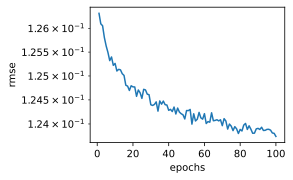

In [10]:
# Submission Model 1
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, learning_rate, weight_decay, batch_size, net, loss_func, optimizor):
    train_ls, _ = train(train_features, train_labels, None, None, batch_size, net, num_epochs, loss_func, optimizor)
    d2dl.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('/Users/yanzheyuan/coding/dataset/house-prices-advanced-regression-techniques/submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_raw, num_epochs, learning_rate, weight_decay, batch_size, net_1, loss_func, optimizor_1)


train rmse 0.063824


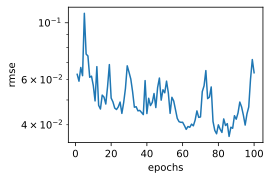

In [11]:
# Submission Model 2
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, learning_rate, weight_decay, batch_size, net, loss_func, optimizor):
    train_ls, _ = train(train_features, train_labels, None, None, batch_size, net, num_epochs, loss_func, optimizor)
    d2dl.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('/Users/yanzheyuan/coding/dataset/house-prices-advanced-regression-techniques/submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_raw, num_epochs, learning_rate, weight_decay, batch_size, net_2, loss_func, optimizor_2)


## Conclusion

- **Results** `rmse in test set`
  - lr: 0.15003
  - mlp: 0.24x

- Actually the linear model is pretty good.
- Obviously the MLP model is overfitting.
- Ensemble Learning may be tried in the future, and it is proved to be effective in this task since the highest ones in the leaderboard are all stacked ensemble models.
  - Sklearn is needed but not for this PyTorch demo
  - will give a try when i have time 

## Visualization

- This function is defined in d2dl
- 绘制对数坐标图：
  - semilogx()，semilogy()，loglog()。它们分别表示对X轴，Y轴，XY轴取对数。

In [12]:
# This function is defined in d2dl
def semilogy_copy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5,2.5)):
    d2dl.set_figsize(figsize)
    d2dl.plt.xlabel(x_label)
    d2dl.plt.ylabel(y_label)
    d2dl.plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        d2dl.plt.semilogy(x2_vals,y2_vals,linestyle=':')
        d2dl.plt.legend(legend)